## Capstone Project

In [81]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from statsmodels.tsa.seasonal import seasonal_decompose, STL
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import Ridge
from sklearn.metrics import  mean_absolute_error,mean_squared_error
from sklearn.pipeline import Pipeline
from sklearn import set_config

### The Data: Wake County Housing and Demographics

The dataset for the capstone project consists of four `.csv` files.
Two are generated by Wake County’s Computer Assisted Mass Appraisal (CAMA) system that can be found on its website (https://www.wake.gov/departments-government/tax-administration/data-files-statistics-and-reports/real-estate-property-data-files).
The other two are from 2019-2023 American Community Survey 5-Year Estimates that can be tabulated from US Census's website https://data.census.gov/.
The file names and descriptions of the data are as follows:

- `sales.csv`: Qualified sales in Wake County from October 2nd, 2023, to September 22nd, 2025, and information on zoning, location and some property characteristics.
- `properties.csv`: Property characteristics of all the properties in Wake County. Code Description.pdf provides the meaning behind the coded features' values.
- `income.csv`: Median household income of Wake County's 20 townships.
- `population.csv`: Population of Wake County's 20 townships.

Each dataset is loaded below, and basic info displayed.

In [82]:
sales = pd.read_csv('Capstone_data/sales.csv')
properties = pd.read_csv('Capstone_data/properties.csv')
income = pd.read_csv('Capstone_data/income.csv')
population = pd.read_csv('Capstone_data/population.csv')

C:\Users\megha\AppData\Local\Temp\ipykernel_26892\147455472.py:2: DtypeWarning: Columns (12,33,47,70,71,72,79) have mixed types. Specify dtype option on import or set low_memory=False.
  properties = pd.read_csv('Capstone_data/properties.csv')


In [83]:
sales.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 56293 entries, 0 to 56292
Data columns (total 41 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   REID                           56293 non-null  int64  
 1   PIN_NUM                        56293 non-null  int64  
 2   PIN_EXT                        56293 non-null  int64  
 3   SALE_DEED_BOOK                 56293 non-null  int64  
 4   SALE_DEED_PAGE                 56293 non-null  int64  
 5   SALE_PRICE                     56293 non-null  int64  
 6   SALE_DATE                      56293 non-null  object 
 7   SALE_TYPE                      56293 non-null  object 
 8   PARCEL_ASSD_VALUE_ATSALE       56166 non-null  float64
 9   LAND_ASSD_VALUE_ATSALE         55762 non-null  float64
 10  PARCEL_DEEDED_ACREAGE_ATSALE   56293 non-null  float64
 11  TOTAL_HEATED_AREA_ATSALE       43622 non-null  float64
 12  PARCEL_ASSD_VALUE_CURRENT      56227 non-null 

In [84]:
sales.head()

,REID,PIN_NUM,PIN_EXT,SALE_DEED_BOOK,SALE_DEED_PAGE,SALE_PRICE,SALE_DATE,SALE_TYPE,PARCEL_ASSD_VALUE_ATSALE,LAND_ASSD_VALUE_ATSALE,...,TOWNSHIP_DESC,FIRE_DISTRICT,SPECIAL_DISTRICT,STREET_NUM,DIRECTIONAL_PREFIX,STREET_NAME,STREET_TYPE,DIRECTIONAL_SUFFIX,STREET_MISC,ZIP
0,491531,1851807038,0,20017,1975,135000,9/22/2025,Land,39996.0,39996.0,...,Wake Forest,NaN,NaN,0,NaN,LATHAM OAKS,AVE,NaN,NaN,27587.0
1,518746,1700273853,0,20017,2049,301000,9/22/2025,Package,286878.0,65000.0,...,St. Mary's,NaN,NaN,292,NaN,GRAND SILO,RD,NaN,NaN,27603.0
2,312870,1850505543,0,20017,2123,665000,9/22/2025,Package,655524.0,100000.0,...,Wake Forest,NaN,NaN,6121,NaN,TIFFIELD,WAY,NaN,NaN,27587.0
3,514138,1731556290,0,20018,82,297500,9/22/2025,Package,281716.0,50000.0,...,St. Mary's,NaN,NaN,6654,NaN,GIBRALTAR ROCK,DR,NaN,NaN,27610.0
4,209630,1747431475,0,20017,1972,298000,9/22/2025,Package,360700.0,130000.0,...,WAKE FOREST,NaN,NaN,4244,NaN,CASHEW,DR,NaN,NaN,27616.0


In [85]:
sales['SALE_DATE'] = pd.to_datetime(sales['SALE_DATE'])

In [86]:
sales['SALE_DATE'].max()

Timestamp('2025-09-22 00:00:00')

In [87]:
sales['SALE_DATE'].min()

Timestamp('2023-10-02 00:00:00')

In [88]:
properties.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 463693 entries, 0 to 463692
Data columns (total 87 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   OWNER1                          463692 non-null  object 
 1   OWNER2                          97183 non-null   object 
 2   Mailing_address1                463693 non-null  object 
 3   Mailing_Address2                463657 non-null  object 
 4   Mailing_Address3                25442 non-null   object 
 5   REAL_ESTATE_ID                  463693 non-null  int64  
 6   CARD_NUMBER                     463693 non-null  int64  
 7   NUMBER_OF_CARDS                 463693 non-null  int64  
 8   Street_Number                   463693 non-null  int64  
 9   Street_Prefix                   17549 non-null   object 
 10  Street_Name                     463693 non-null  object 
 11  Street_Type                     462312 non-null  object 
 12  Street_Suffix   

In [89]:
properties.head(3)

,OWNER1,OWNER2,Mailing_address1,Mailing_Address2,Mailing_Address3,REAL_ESTATE_ID,CARD_NUMBER,NUMBER_OF_CARDS,Street_Number,Street_Prefix,...,Land_Deferred_code,Land_Deferred_Amount,Historic_Deferred_code,Historic_Deferred_Amount,RECYCLED_UNITS,Disq_and_Qual_flag,Land_Disq_and_Qual_flag,TYPE_AND_USE,PHYSICAL_CITY,PHYSICAL_ZIP_CODE
0,NORTHGATE PROPERTIES LLC,NaN,8465 LENTIC CT,RALEIGH NC 27615-4964,NaN,1,1,1,1506,NaN,...,NaN,0,NaN,0,0,NaN,NaN,NaN,RALEIGH,27604.0
1,BONES 13 LLC,NaN,306 MIDENHALL WAY,CARY NC 27513-5569,NaN,3,1,2,6012,NaN,...,NaN,0,NaN,0,0,A,NaN,20.0,RALEIGH,27617.0
2,BONES 13 LLC,NaN,306 MIDENHALL WAY,CARY NC 27513-5569,NaN,3,2,2,6012,NaN,...,NaN,0,NaN,0,0,A,NaN,34.0,RALEIGH,27617.0


In [90]:
income.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20 entries, 0 to 19
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   TOWNSHIP  20 non-null     object
 1   INCOME    20 non-null     int64 
dtypes: int64(1), object(1)
memory usage: 452.0+ bytes


Rank townships by median household income from high to low.

In [91]:
income.sort_values(by='INCOME', ascending=False)

,TOWNSHIP,INCOME
12,New Light,213040
1,Buckhorn,198299
0,Bartons Creek,180346
19,White Oak,141515
3,Cedar Fork,132231
4,Holly Springs,128048
6,Leesville,117615
18,Wake Forest,114954
10,Middle Creek,108688
2,Cary,108522


In [92]:
population.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20 entries, 0 to 19
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   TOWNSHIP    20 non-null     object
 1   POPULATION  20 non-null     int64 
dtypes: int64(1), object(1)
memory usage: 452.0+ bytes


Rank townships by population from high to low.

In [93]:
population.sort_values(by='POPULATION', ascending=False)

,TOWNSHIP,POPULATION
14,Raleigh,131023
19,White Oak,115701
18,Wake Forest,100941
16,St. Matthews,84204
11,Neuse,82053
2,Cary,80758
15,St. Marys,73055
5,House Creek,63429
10,Middle Creek,63028
3,Cedar Fork,62168


### Background and Objective
Since the global pandemic Covid broke in 2020, the state of North Carolina has seen a surge of population from migration both nationally and internationally. Within the US, tens of thousands of people moved from New York, Pennsylvania and California to North Carolina every year attracted by its high-quality public education, newer infrastructure, great parks, good public safety, lower income and property tax rate and so on, bidding the housing prices up significantly. Wake county sits in the heart of the research triangle. It has seen its personal property tax base increase from 6.0 billion to 11.6 billion from 2020 to 2025, almost doubled.


The objective of this analysis is to predict single family housing prices in Wake County, North Carolina based on property location and characteristics. It aims to find what factors predict single family housing prices in Wake County, and to provide insights into the hot North Carolina real estate market for relocating families.

#### Data Cleaning
Drop columns in `sales` DataFrame that are repetitive or uninformative and select columns in `properties` DataFrame that provides additional information on properties sold in the past year. Drop columns related to assessed property values because their correlation with sales price is very high and provides little insight into the factors contributing to the value.

In [94]:
sales2 = sales.drop(['LAND_VALUE_ASSD','CORP_LIMIT_DESC','PLANNING_JURISDICTION','BLDG_VALUE_ASSD','TOTAL_PROP_VALUE_ASSD','TOTAL_OBLDG_VALUE_ASSD','PARCEL_ASSD_VALUE_ATSALE','LAND_ASSD_VALUE_ATSALE','DEEDED_ACREAGE','PARCEL_ASSD_VALUE_CURRENT','TOTAL_HEATED_AREA','LAND_ASSD_VALUE_CURRENT','PARCEL_DEEDED_ACREAGE_CURRENT','PIN_NUM','PIN_EXT','SALE_DEED_BOOK','SALE_DEED_PAGE', 'VCS','STREET_NUM','DIRECTIONAL_PREFIX','STREET_NAME','STREET_MISC','DIRECTIONAL_SUFFIX','TOTAL_HEATED_AREA_CURRENT','TOWNSHIP','FIRE_DISTRICT','SPECIAL_DISTRICT','ZIP'],axis=1)
sales2.shape

(56293, 13)

Select SALE_TYPE that is Package meaning both land and housing were sold in the transaction.

In [95]:
sales3 = sales2[sales2['SALE_TYPE']=='Package']
sales3.shape

(42601, 13)

In [96]:
sales4 = sales3.drop_duplicates()
sales4.shape

(42507, 13)

In [97]:
properties2 = properties[['REAL_ESTATE_ID', 'Land_classification','NUM_of_Rooms','UNITS','UTILITIES','Year_of_Addition','Foundation_Basement','Exterior_Wall','HEAT',  'AIR', 'BATH','GRADE', 'Assessed_Grade_Difference','PHYSICAL_CITY','TYPE_AND_USE']] 
properties2.shape

(463693, 15)

In [98]:
properties3 = properties2.drop_duplicates()
properties3.shape


(456410, 15)

Merge `sales3` and `properties2` DataFrames based on key `REAL_ESTATE_ID` or `REID`, while keeping only records of properties in the `sales3` DataFrame.

In [99]:
df = pd.merge(left = sales4, right = properties3, left_on = "REID", right_on = "REAL_ESTATE_ID", how = "left")

In [100]:
df.shape

(42865, 28)

In [101]:
df.head()

,REID,SALE_PRICE,SALE_DATE,SALE_TYPE,PARCEL_DEEDED_ACREAGE_ATSALE,TOTAL_HEATED_AREA_ATSALE,ZONING,BLDG_USE_DESC,YEAR_BUILT,STORY_HEIGHT,...,Year_of_Addition,Foundation_Basement,Exterior_Wall,HEAT,AIR,BATH,GRADE,Assessed_Grade_Difference,PHYSICAL_CITY,TYPE_AND_USE
0,518746,301000,2025-09-22,Package,0.05,1568.0,MF-A,SINGLFAM,2025.0,2S,...,0.0,A,Z,A,A,D,C,100.0,RALEIGH,1.0
1,312870,665000,2025-09-22,Package,0.22,4575.0,GR3,SINGLFAM,2004.0,1.88S,...,0.0,D,A,A,A,F,B,120.0,WAKE FOREST,1.0
2,514138,297500,2025-09-22,Package,0.05,1428.0,R-6,SINGLFAM,2025.0,2S,...,0.0,NaN,Z,A,A,D,C,100.0,RALEIGH,1.0
3,209630,298000,2025-09-22,Package,0.30,1584.0,R-4,SINGLFAM,1995.0,1S,...,0.0,D,A,A,A,C,C+05,105.0,RALEIGH,1.0
4,518906,423500,2025-09-22,Package,0.13,NaN,R4,NaN,NaN,NaN,...,0.0,NaN,NaN,NaN,NaN,NaN,NaN,0.0,RALEIGH,NaN


Convert all the township names to a uniform format to prepare for merging.

In [102]:
df['TOWNSHIP_DESC'] = df['TOWNSHIP_DESC'].astype(str)
print(df['TOWNSHIP_DESC'].dtype)

object


In [103]:
df['TOWNSHIP'] = df['TOWNSHIP_DESC'].str.replace("'", "", regex=False).str.title()


In [104]:
df['TOWNSHIP'].value_counts().shape[0]

20

In [105]:
unique_townships_sorted = sorted(df['TOWNSHIP'].unique())
unique_townships_sorted 

['Bartons Creek',
 'Buckhorn',
 'Cary',
 'Cedar Fork',
 'Holly Springs',
 'House Creek',
 'Leesville',
 'Little River',
 'Marks Creek',
 'Meredith',
 'Middle Creek',
 'Neuse',
 'New Light',
 'Panther Branch',
 'Raleigh',
 'St. Marys',
 'St. Matthews',
 'Swift Creek',
 'Wake Forest',
 'White Oak']

Now we can merge the data frame with income and poulation data frames.

In [106]:
df1 = pd.merge(left = df, right = income, left_on = "TOWNSHIP", right_on = "TOWNSHIP")

In [107]:
df2 = pd.merge(left = df1, right = population, left_on = "TOWNSHIP", right_on = "TOWNSHIP")

Select single family property type. The corresponding value is 1 in the TYPE_AND_USE column.

In [108]:
df2 = df2[df2['TYPE_AND_USE']==1]

Double check with column Building Use Description and number of units.

In [109]:
df2['UNITS'].value_counts()

UNITS
1.0    39692
0.0      443
4.0        1
Name: count, dtype: int64

In [110]:
df2['BLDG_USE_DESC'].value_counts()

BLDG_USE_DESC
SINGLFAM    40131
TWOFAM          2
WAREHSE         1
CHURCH          1
THREEFAM        1
Name: count, dtype: int64

Remove the rows that are inconsistent with single family usage, and drop columns that are repetitive and have uniform values.


In [111]:
df2 = df2[(df2['BLDG_USE_DESC'] == 'SINGLFAM') & (df2['UNITS'] == 1)]
df2.shape

(39687, 31)

In [112]:
df2 = df2.drop(['TYPE_AND_USE','REAL_ESTATE_ID','BLDG_USE_DESC','UNITS','SALE_TYPE'],axis=1)
df2.shape

(39687, 26)

Retain only the letters in Grade to match the values in CodeDescription.pdf.

In [113]:
df2 = df2[df2["GRADE"] != "0"]
df2["GRADE"] = df2["GRADE"].str.extract(r'([A-Z]{1,2})')
df2["GRADE"].value_counts()


GRADE
C     21000
B     12400
A      5136
AA      752
D       326
E        20
Name: count, dtype: int64

In [114]:
df2['UTILITIES'].value_counts()

UTILITIES
ALL    29256
E       7218
WSE     1372
WE      1192
GE       123
WGE      107
W         85
SE        16
SGE       12
WS         5
WG         3
S          3
WSG        1
Name: count, dtype: int64

Map those letters to one, two, three or four types of utilities for ordinal encoding purposes.

In [115]:
utility_map = {
    "ALL": 4,
    "E": 1,
    "WSE": 3,
    "WE": 2,
    "GE": 2,
    "WGE": 3,
    "W": 1,
    "SE": 2,
    "SGE": 3,
    "WS": 2,
    "WG": 2,
    "S": 1,
    "WSG": 3
}

In [116]:
df2["UTILITIES_ORD"] = df2["UTILITIES"].map(utility_map).astype("Int64").astype("string")

In [117]:
df2["UTILITIES_ORD"].value_counts()

UTILITIES_ORD
4    29256
1     7306
3     1492
2     1339
Name: count, dtype: Int64

In [118]:
df2["UTILITIES_ORD"].dtype

string[python]

In [119]:
df2 = df2.drop(columns=["UTILITIES"])

Convert story height from object to float.

In [120]:
df2['STORY_HEIGHT'] = (
    df2['STORY_HEIGHT']
    .str.replace('S', '', regex=False)  # remove 'S'
    .astype(float)                      # convert to number
)

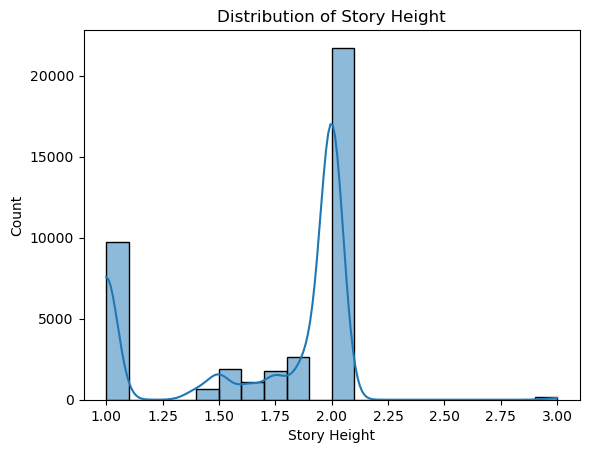

In [121]:
sns.histplot(df2['STORY_HEIGHT'], bins=20, kde=True)
plt.xlabel('Story Height')
plt.ylabel('Count')
plt.title('Distribution of Story Height')
plt.savefig("Capstone_image/story_height_hist_plot.png")

The distribution shows that most of the single-family houses sold had a story height of 2. Story heights of 1 or 2 are the most common.

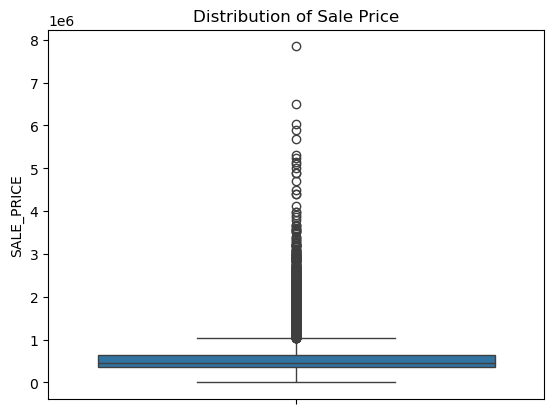

In [122]:
sns.boxplot(df2['SALE_PRICE'])
plt.title("Distribution of Sale Price")
plt.savefig("Capstone_image/sale_price_box_plot.png")


The box plot shows that the upper limit for standard range of single-family sales in Wake County is a little above 1 million USD, with median sales price of around half a million USD. 



Eliminate records where sale price is lower than 100,000 USD to avoid erroneous entries.

In [123]:
df2 = df2.loc[(df2['SALE_PRICE']>100000)]

Identify outliers using the 3×𝐼𝑄𝑅 rule to catch extreme situations. The Interquartile Range (IQR) is the difference between the third and first quartile.

In [124]:
first_quartile = df2['SALE_PRICE'].quantile(.25)
third_quartile = df2['SALE_PRICE'].quantile(.75)
print(first_quartile)
print(third_quartile)

352500.0
630000.0


In [125]:
iqr = third_quartile - first_quartile
lower = first_quartile - 3*iqr
upper = third_quartile + 3*iqr
print(lower)
print(upper)

-480000.0
1462500.0


Keep records where sale price is lower than 1,462,500 USD to avoid extreme cases.

In [126]:
df3 = df2.loc[(df2['SALE_PRICE']<upper)]

In [127]:
df3.info()

<class 'pandas.core.frame.DataFrame'>
Index: 38477 entries, 0 to 42864
Data columns (total 26 columns):
 #   Column                        Non-Null Count  Dtype         
---  ------                        --------------  -----         
 0   REID                          38477 non-null  int64         
 1   SALE_PRICE                    38477 non-null  int64         
 2   SALE_DATE                     38477 non-null  datetime64[ns]
 3   PARCEL_DEEDED_ACREAGE_ATSALE  38477 non-null  float64       
 4   TOTAL_HEATED_AREA_ATSALE      38437 non-null  float64       
 5   ZONING                        38477 non-null  object        
 6   YEAR_BUILT                    38477 non-null  float64       
 7   STORY_HEIGHT                  38477 non-null  float64       
 8   DESIGN_STYLE_DESC             38477 non-null  object        
 9   TOWNSHIP_DESC                 38477 non-null  object        
 10  STREET_TYPE                   38382 non-null  object        
 11  Land_classification           384

#### 
Time Series  Analysis for Properties with Duplicate Keys


Some properties that have duplicate keys were transacted more than once. Some at similar prices and some at higher prices after improvement. We apply time series analysis to these records to see the trend.

In [128]:
# Create DataFrame dupe_keys for the REIDs that appear more than once
dupe_keys = df3[df3['REID'].duplicated()]
dupe_keys.shape

(1796, 26)

In [129]:
time_series = dupe_keys[['SALE_DATE','SALE_PRICE']].set_index('SALE_DATE')

In [130]:
stl = STL(time_series['SALE_PRICE'], period=12)
results = stl.fit()

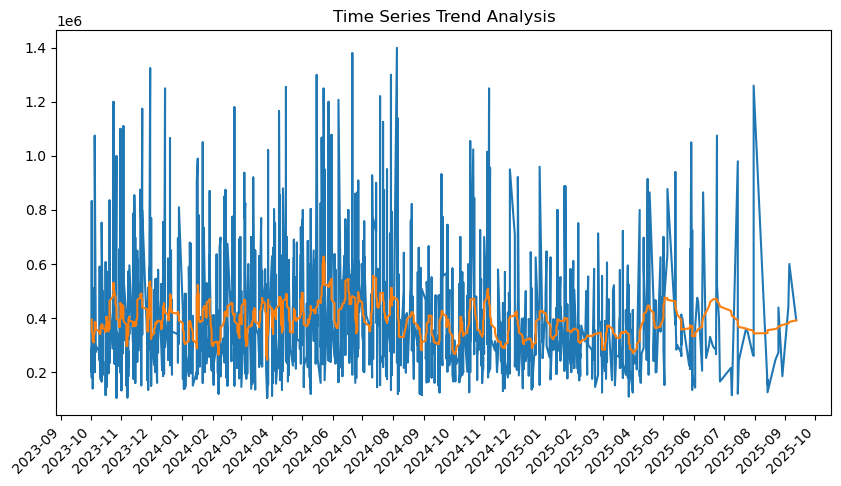

In [131]:

##sns.lineplot(data = dupe_keys, x='SALE_DATE', y='SALE_PRICE')
plt.figure(figsize=(10, 5))
plt.plot(time_series['SALE_PRICE'])
plt.plot(results.trend)
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=1))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
plt.xticks(rotation=45, ha="right")
plt.title("Time Series Trend Analysis")
plt.savefig("Capstone_image/time_series_trend_analysis.png")


A time-series analysis of repeat-sale properties indicates that Wake County home prices largely oscillated around a stable mean between October 2023 and October 2025. Prices began to decline noticeably in July 2025, followed by a gradual recovery starting in September.

### Baseline Regression Model with Quantitative Features
Build a baseline linear regression model with quantitative features.

In [132]:

numerical_columns= df3.select_dtypes(include=['float64', 'int64']).columns.tolist()
print(numerical_columns)

['REID', 'SALE_PRICE', 'PARCEL_DEEDED_ACREAGE_ATSALE', 'TOTAL_HEATED_AREA_ATSALE', 'YEAR_BUILT', 'STORY_HEIGHT', 'NUM_of_Rooms', 'Year_of_Addition', 'Assessed_Grade_Difference', 'INCOME', 'POPULATION']


In [133]:
df3_num = df3[numerical_columns]
df3_num = df3_num.dropna()

In [134]:
X = df3_num.drop(['SALE_PRICE','REID'], axis=1)
y = df3_num['SALE_PRICE']

In [135]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [136]:
linreg_pipe = Pipeline([('scaler', StandardScaler()),
                        ('linreg', LinearRegression())])
linreg_pipe.fit(X_train, y_train)
linreg_train_mse = mean_squared_error(y_train, linreg_pipe.predict(X_train))
linreg_test_mse = mean_squared_error(y_test, linreg_pipe.predict(X_test))
print(linreg_train_mse)
print(linreg_test_mse)


10138658684.38313
10155400016.686243


In [137]:

coefs = pd.DataFrame({
    'feature': X.columns,
    'coefficient': linreg_pipe.named_steps['linreg'].coef_
}).assign(abs_coef=lambda df: df['coefficient'].abs()) \
  .sort_values('abs_coef', ascending=False)
print(coefs)

                        feature   coefficient      abs_coef
1      TOTAL_HEATED_AREA_ATSALE  1.412661e+05  1.412661e+05
6     Assessed_Grade_Difference  9.051578e+04  9.051578e+04
7                        INCOME  1.911907e+04  1.911907e+04
3                  STORY_HEIGHT -1.898907e+04  1.898907e+04
8                    POPULATION  1.378050e+04  1.378050e+04
2                    YEAR_BUILT -1.203660e+04  1.203660e+04
0  PARCEL_DEEDED_ACREAGE_ATSALE  5.438013e+03  5.438013e+03
5              Year_of_Addition  5.015998e+03  5.015998e+03
4                  NUM_of_Rooms -9.458745e-11  9.458745e-11


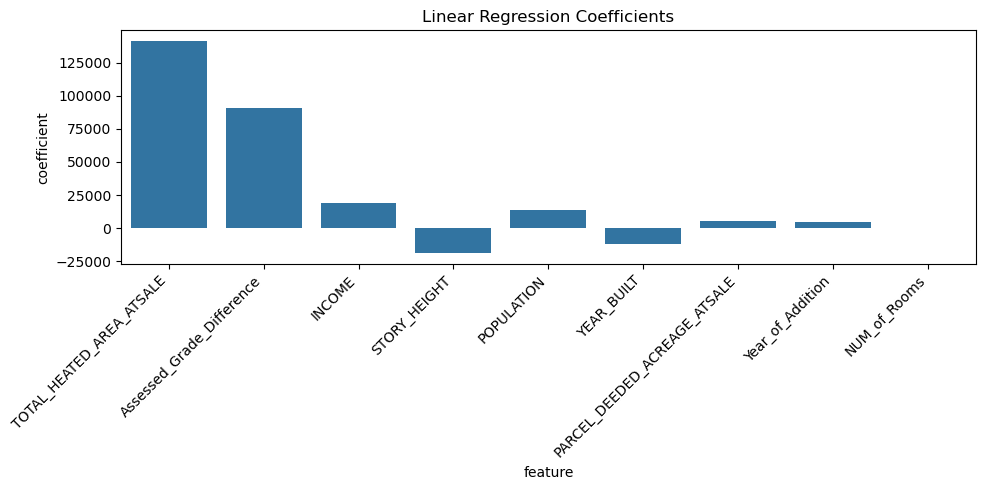

In [138]:
plt.figure(figsize=(10, 5))
sns.barplot(data=coefs, x="feature", y="coefficient")
plt.xticks(rotation=45, ha="right")
plt.title("Linear Regression Coefficients")
plt.tight_layout()
plt.savefig("Capstone_image/linreg_coefficients.png")

The baseline linear regression model using all quantitative features indicates that sale price is positively associated with total heated area at sale, assessed grade difference (which reflects the property’s overall condition relative to comparable properties), median household income and population of the town, parcel deeded acreage at sale, and year of addition. In contrast, sale price is negatively associated with story height and year built, while the number of rooms has no impact on sale price. 

The top five most influential predictors are total heated area at sale, assessed grade difference, median household income, story height and population. These quantitative factors are great representations of the house's size, quality and location, that substantially affect residential properties’ value.

### Accounting for Nonlinearity
Apply a third-degree polynomial transformation to the features and use a Sequential Feature Selector to choose the eight most important features.

In [139]:
sequential_pipe = Pipeline([('poly_features', PolynomialFeatures(degree = 3, include_bias = False)),
                            ('scaler', StandardScaler()),
                            ('selector', SequentialFeatureSelector(LinearRegression(), n_features_to_select=8)),
                           ('linreg', LinearRegression())])
sequential_pipe 

Pipeline(steps=[('poly_features',
                 PolynomialFeatures(degree=3, include_bias=False)),
                ('scaler', StandardScaler()),
                ('selector',
                 SequentialFeatureSelector(estimator=LinearRegression(),
                                           n_features_to_select=8)),
                ('linreg', LinearRegression())])

In [140]:
sequential_pipe.fit(X_train, y_train)
sequential_train_mse = mean_squared_error(y_train, sequential_pipe.predict(X_train))
sequential_test_mse = mean_squared_error(y_test, sequential_pipe.predict(X_test))

In [141]:
print(sequential_train_mse)
print(sequential_test_mse)

8717676988.976036
8835363717.903387


In [142]:
mse_percentage_change = (sequential_test_mse - linreg_test_mse)*100/linreg_test_mse
print(f"{mse_percentage_change:.2f}%")

-13.00%


The model performs better than the baseline.

Calculate the mean absolute error for a better perspective of model's prediction power.

In [178]:
sequential_train_mae = mean_absolute_error(y_train, sequential_pipe.predict(X_train))
sequential_test_mae = mean_absolute_error(y_test, sequential_pipe.predict(X_test))

In [179]:
print(sequential_train_mae)
print(sequential_test_mae)

62591.18121655165
62959.74927748631


In [143]:
sfs = sequential_pipe.named_steps['selector']
mask = sfs.get_support() 
selected_indices = mask.nonzero()[0]
print(selected_indices)
poly = sequential_pipe.named_steps['poly_features']
feature_names = poly.get_feature_names_out(X.columns)
selected_feature_names = feature_names[selected_indices]
print(selected_feature_names)

[  8  20  23 101 104 160 162 218]
['POPULATION' 'TOTAL_HEATED_AREA_ATSALE STORY_HEIGHT'
 'TOTAL_HEATED_AREA_ATSALE Assessed_Grade_Difference'
 'TOTAL_HEATED_AREA_ATSALE^2 STORY_HEIGHT'
 'TOTAL_HEATED_AREA_ATSALE^2 Assessed_Grade_Difference'
 'YEAR_BUILT INCOME^2' 'YEAR_BUILT POPULATION^2' 'POPULATION^3']


After applying a third-degree polynomial transformation and selecting the eight most important features, the mean squared error decreased by 13% compared to the baseline. The model’s mean absolute error on the test set is $62,959, indicating strong predictive performance for single-family home prices. As expected, these eight features represent combinations and interactions of the top five most influential features from the baseline linear regression model.

### Regression Model with Only Qualitative Features

To understand the predictive power of qualitative features, we are building models with only those features, and comparing the performance to the baseline regression model.

In [144]:
categorical_columns = df3.select_dtypes(include=['object', 'string']).columns.tolist()
print(categorical_columns)

['ZONING', 'DESIGN_STYLE_DESC', 'TOWNSHIP_DESC', 'STREET_TYPE', 'Land_classification', 'Foundation_Basement', 'Exterior_Wall', 'HEAT', 'AIR', 'BATH', 'GRADE', 'PHYSICAL_CITY', 'TOWNSHIP', 'UTILITIES_ORD']


Among these columns, Grade and Bath are ordinal variables, meaning their values have a natural ranking, while the remaining variables are nominal and do not have an inherent order.

In [145]:

df3_cat = df3[categorical_columns + ['SALE_PRICE']]
df3_cat = df3_cat.dropna()

In [146]:
X2 = df3_cat.drop(columns=['SALE_PRICE'])
y2 = df3_cat['SALE_PRICE']
X2.head()

,ZONING,DESIGN_STYLE_DESC,TOWNSHIP_DESC,STREET_TYPE,Land_classification,Foundation_Basement,Exterior_Wall,HEAT,AIR,BATH,GRADE,PHYSICAL_CITY,TOWNSHIP,UTILITIES_ORD
0,MF-A,Townhouse,St. Mary's,RD,R,A,Z,A,A,D,C,RALEIGH,St. Marys,4
1,GR3,Conventional,Wake Forest,WAY,R,D,A,A,A,F,B,WAKE FOREST,Wake Forest,2
3,R-4,Conventional,WAKE FOREST,DR,R,D,A,A,A,C,C,RALEIGH,Wake Forest,1
5,R-30,Conventional,Wake Forest,DR,R,D,Z,A,A,D,A,WAKE FOREST,Wake Forest,3
6,R-30,Conventional,Middle Creek,LN,R,D,A,A,A,F,A,RALEIGH,Middle Creek,1


In [147]:
ordinal_cols = ['GRADE','BATH','UTILITIES_ORD']
nominal_cols = [c for c in categorical_columns if c not in ordinal_cols]

In [148]:
nominal_cols

['ZONING',
 'DESIGN_STYLE_DESC',
 'TOWNSHIP_DESC',
 'STREET_TYPE',
 'Land_classification',
 'Foundation_Basement',
 'Exterior_Wall',
 'HEAT',
 'AIR',
 'PHYSICAL_CITY',
 'TOWNSHIP']

In [149]:
df3['Foundation_Basement'].value_counts()

Foundation_Basement
D    17817
A     4277
B     1325
C       15
E        2
Name: count, dtype: int64

In [150]:
df3['Exterior_Wall'].value_counts()

Exterior_Wall
A    22293
Z    12164
B     2934
D      912
G       59
C       44
I       17
H       17
Q       15
L        8
K        8
J        6
Name: count, dtype: int64

In [151]:
df3['HEAT'].value_counts()

HEAT
A    38364
I       76
J       36
Name: count, dtype: int64

In [152]:
df3['AIR'].value_counts()

AIR
A    38145
H      318
G       14
Name: count, dtype: int64

In [153]:
X2_train, X2_test, y2_train, y2_test = train_test_split(X2, y2, test_size=0.2, random_state=42)

Decode Grade and Bath's order according to CodeDescription.pdf on Wake County's website and define transformers.

In [154]:
ordinal_transformer = OrdinalEncoder(categories=[
    ["E", "D", "C", "B", "A", "AA"],   # Grade order
    ["H", "I", "J","A","B","C","D","E","F"],   # Bath order
     ["1","2","3","4"]  # Utilities order
])

onehot_transformer = OneHotEncoder(drop='if_binary', handle_unknown='ignore', sparse_output=False)

Explore how nonnumeric factors like grade, bath, utilities, basement and exterior wall influence housing price. Including street types, zoning township, or city will cause the model to overfit. And heat and air have an unbalanced class problem. So, we exclude these nonnumeric factors in the model.

In [155]:
preprocessor = ColumnTransformer(
    transformers=[
        ("ord", ordinal_transformer, ordinal_cols),
        ("cat", onehot_transformer, ['Foundation_Basement','Exterior_Wall']), 
    ],
    remainder='drop'
) #Build the ColumnTransformer

In [156]:
nonnumeric_pipe = Pipeline([
        ("preprocess", preprocessor),
        ("linreg", LinearRegression())
    ])
nonnumeric_pipe 

Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('ord',
                                                  OrdinalEncoder(categories=[['E',
                                                                              'D',
                                                                              'C',
                                                                              'B',
                                                                              'A',
                                                                              'AA'],
                                                                             ['H',
                                                                              'I',
                                                                              'J',
                                                                              'A',
                                                                              'B',
                                                                              'C',
                                                                              'D',
                                                                              'E',
                                                                              'F'],
                                                                             ['1',
                                                                              '2',
                                                                              '3',
                                                                              '4']]),
                                                  ['GRADE', 'BATH',
                                                   'UTILITIES_ORD']),
                                                 ('cat',
                                                  OneHotEncoder(drop='if_binary',
                                                                handle_unknown='ignore',
                                                                sparse_output=False),
                                                  ['Foundation_Basement',
                                                   'Exterior_Wall'])])),
                ('linreg', LinearRegression())])

In [157]:
nonnumeric_pipe.fit(X2_train, y2_train)
nonnumeric_train_mse = mean_squared_error(y2_train, nonnumeric_pipe.predict(X2_train))
nonnumeric_test_mse = mean_squared_error(y2_test, nonnumeric_pipe.predict(X2_test))
print(nonnumeric_train_mse)
print(nonnumeric_test_mse)


27266876667.946526
27638047738.541397


Compare MSE with baseline model built with numeric factors.

In [158]:
mse_percentage_change = (nonnumeric_test_mse - linreg_test_mse)*100/linreg_test_mse
print(f"{mse_percentage_change:.2f}%")

172.15%


When the linear regression model is built using only qualitative features, the mean squared error increases by 172% compared to the baseline. This is a weak model.

### Regression Model with Both Quantitative and Qualitative Features

Get data frame X3 with both quantitative and qualitative features used in the separate linear regression models.

In [159]:
df4 = df3[numerical_columns+['Foundation_Basement','Exterior_Wall','GRADE','BATH','UTILITIES_ORD']].drop(['REID'], axis=1).dropna()
df4.shape

(23345, 15)

In [160]:
X3 = df4.drop(['SALE_PRICE'], axis=1)
y3 = df4['SALE_PRICE']
X3.head()

,PARCEL_DEEDED_ACREAGE_ATSALE,TOTAL_HEATED_AREA_ATSALE,YEAR_BUILT,STORY_HEIGHT,NUM_of_Rooms,Year_of_Addition,Assessed_Grade_Difference,INCOME,POPULATION,Foundation_Basement,Exterior_Wall,GRADE,BATH,UTILITIES_ORD
0,0.05,1568.0,2025.0,2.00,0.0,0.0,100.0,75067,73055,A,Z,C,D,4
1,0.22,4575.0,2004.0,1.88,0.0,0.0,120.0,114954,100941,D,A,B,F,2
3,0.30,1584.0,1995.0,1.00,0.0,0.0,105.0,114954,100941,D,A,C,C,1
5,0.70,2056.0,1995.0,2.00,0.0,0.0,133.0,114954,100941,D,Z,A,D,3
6,0.77,4045.0,2022.0,2.00,0.0,0.0,129.0,108688,63028,D,A,A,F,1


In [161]:
preprocessor_all = ColumnTransformer(
    transformers=[
        ("ord", ordinal_transformer, ordinal_cols),
        ("cat", onehot_transformer, ['Foundation_Basement','Exterior_Wall']), 
    ],
    remainder=StandardScaler()
) #Build the ColumnTransformer

In [162]:
pipe_all = Pipeline([
        ("preprocess", preprocessor),
        ("ridge", Ridge(alpha=10))
    ]) #Build the Pipeline

In [163]:
X3_train, X3_test, y3_train, y3_test = train_test_split(X3, y3, test_size=0.2, random_state=42)

In [164]:
pipe_all.fit(X3_train, y3_train)
all_train_mse = mean_squared_error(y3_train, pipe_all.predict(X3_train))
all_test_mse = mean_squared_error(y3_test, pipe_all.predict(X3_test))
print(all_train_mse)
print(all_test_mse)

27140344478.665585
28961176817.14979


The test MSE of the regression model trained with both quantitative and qualitative features remains substantially higher than the baseline. This is likely because qualitative features introduce noise and multicollinearity, which negatively affect linear regression performance. Therefore, it is preferable to use only quantitative features when predicting housing prices with linear regression models.

### Neural Networks

Next, we investigate different neural network architectures for regression based solely on quantitative features.

In [165]:
import os

os.environ["CUDA_VISIBLE_DEVICES"] = "-1"          # Disables GPU discovery
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"           # Suppress TF C++ logs
os.environ["TF_ENABLE_ONEDNN_OPTS"] = "0"          # Optional: disable oneDNN opts

import tensorflow as tf

from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Sequential

C:\Users\megha\anaconda3\Lib\site-packages\keras\src\export\tf2onnx_lib.py:8: FutureWarning: In the future `np.object` will be defined as the corresponding NumPy scalar.
  if not hasattr(np, "object"):


#### Neural Network #1

Build a neural network that consists of one hidden layer with 10 neurons and ReLU activation functions, and an output layer with a linear activation function.

In [166]:
tf.random.set_seed(42)
NN_model = Sequential([Dense(10, activation = 'relu'),
                       Dense(1, activation = 'linear')])
NN_model.compile(loss = 'mse', metrics = ['mse'])
history = NN_model.fit(X, y, validation_split = 0.2, epochs = 20, verbose = 0)

In [167]:
print(history.history['mse'][-1])
(history.history['val_mse'][-1])

30242869248.0


22466420736.0

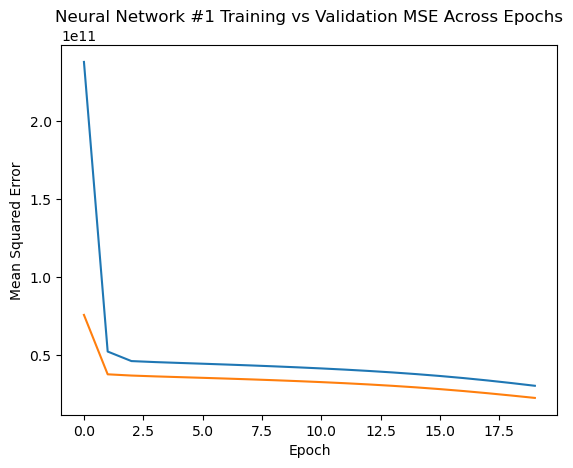

In [168]:
plt.plot(history.history['mse'], label='Training MSE')
plt.plot(history.history['val_mse'], label='Validation MSE')

plt.xlabel('Epoch')
plt.ylabel('Mean Squared Error')
plt.title('Neural Network #1 Training vs Validation MSE Across Epochs')
plt.savefig("Capstone_image/NN1_mse_plot.png")

#### Neural Network #2

Build a neural network with two hidden layers, the first one with 6 neurons and the second one with 7 neurons, followed by an output layer with a linear activation function.

In [170]:
tf.random.set_seed(42)
NN_model2 = Sequential([Dense(6, activation = 'relu'),
                       Dense(7, activation = 'relu'),
                       Dense(1, activation = 'linear')])
NN_model2.compile(loss = 'mse', metrics = ['mse'])
history2 = NN_model2.fit(X, y, validation_split = 0.2, epochs = 20, verbose = 0)

In [171]:
print(history2.history['mse'][-1])
print(history2.history['val_mse'][-1])

19313455104.0
15017862144.0


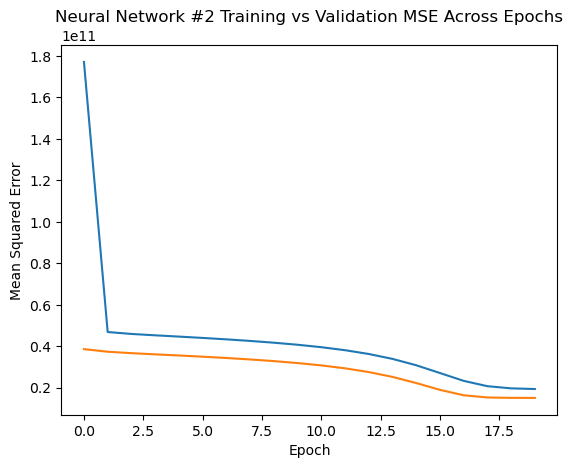

In [172]:
plt.plot(history2.history['mse'], label='Training MSE')
plt.plot(history2.history['val_mse'], label='Validation MSE')

plt.xlabel('Epoch')
plt.ylabel('Mean Squared Error')
plt.title('Neural Network #2 Training vs Validation MSE Across Epochs')
plt.savefig("Capstone_image/NN2_mse_plot.png")

The MSEs from the neural network regression models are still higher than the baseline, indicating that the linear regression model is more suitable for predicting housing prices.